In [1]:
# Core
import re, os, glob
import pandas as pd
from pandas.compat import StringIO
from scipy import stats
import numpy as np
import csv
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime, timedelta
import matplotlib.dates as mdates

## Definitions

In [2]:
def get_plot_height(ax, expansion=1.0):
    plot_height = 0
    for line in ax.lines:
        if max(line.get_ydata()) > plot_height: plot_height = max(line.get_ydata())
        
    return plot_height*expansion

In [3]:
class Vividict(dict):
    def __missing__(self, key):
        value = self[key] = type(self)() # retain local pointer to value
        return value                     # faster to return than dict lookup

## Test Titrations
These are indicator samples that we used to determine when each species and genotype switched to CAM.

In [4]:
test_titrations = pd.read_csv("../Data/Test_titrations.csv")
test_titrations.dropna(inplace=True)
test_titrations["datetime"] = [" ".join([row["Date"], row["Time"]]) for i, row in test_titrations.iterrows()]
test_titrations["datetime"] = [datetime.strptime(dt, "%d %B %Y %H:%M") for dt in test_titrations["datetime"]]
test_titrations.head()

,Date,Time,Sample,Mass_g,pHi,uL_NaOH,pHf,ueq_H,datetime
0,12 February 2019,16:00,AM,0.22245,5.64,831.0,7.03,7.47,2019-02-12 16:00:00
1,12 February 2019,16:00,OR,0.21921,5.97,440.0,7.00,4.01,2019-02-12 16:00:00
2,12 February 2019,16:00,OF,0.23501,5.61,940.0,7.03,8.00,2019-02-12 16:00:00
3,13 February 2019,4:00,OF,0.15241,6.03,523.0,7.03,6.86,2019-02-13 04:00:00
4,13 February 2019,4:00,AM,0.17704,5.28,1246.0,7.01,14.08,2019-02-13 04:00:00


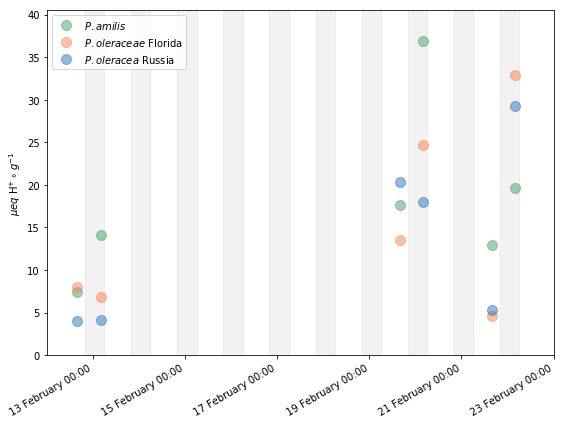

In [5]:
fig, ax = plt.subplots(figsize = (8,6))

for i in range(12, 22, 1):
    rect = mpatches.Rectangle((datetime(2019, 2, i, 20), 0), timedelta(hours = 10), 
                              1000, color='grey', alpha=0.10)
    ax.add_patch(rect) 
    
ax.plot_date(x = test_titrations.loc[test_titrations["Sample"]=="AM"]["datetime"], 
           y = test_titrations.loc[test_titrations["Sample"]=="AM"]["ueq_H"], 
           color = "xkcd:greenish", marker = "o", label = "$P. amilis$", alpha = 0.5, markersize=10)
ax.plot_date(x = test_titrations.loc[test_titrations["Sample"]=="OF"]["datetime"], 
           y = test_titrations.loc[test_titrations["Sample"]=="OF"]["ueq_H"], 
           color = "xkcd:orangish", marker = "o", label = "$P. oleraceae$ Florida", alpha = 0.5, markersize=10)
ax.plot_date(x = test_titrations.loc[test_titrations["Sample"]=="OR"]["datetime"], 
           y = test_titrations.loc[test_titrations["Sample"]=="OR"]["ueq_H"], 
           color = "xkcd:bluish", marker = "o", label = "$P. oleracea$ Russia", alpha = 0.5, markersize=10)
plt.legend(loc = "upper left")

ax.set_xlim([datetime(2019, 2, 12, 0), datetime(2019, 2, 23, 0)])
ax.set_ylim([0, test_titrations["ueq_H"].max()*1.1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %B %H:%M'))
ax.set_ylabel("$\mu eq$ H$^{+}\circ g^{-1}$")
fig.autofmt_xdate()
plt.tight_layout()
# plt.savefig("../Figures/test_titrations.pdf", dpi = 100, transparent=True)

## Porometer
I don't believe that the porometer is measuring anything real about these plants for various reasons.

In [6]:
porometer = pd.read_csv("../Data/Porometer_measurements.csv")
if "Unnamed: 0" in porometer.columns: porometer.drop(labels=["Unnamed: 0"], axis=1, inplace=True)
porometer.dropna(inplace=True, how="all")
porometer["datetime"] = [datetime.strptime(dt, "%d %B %Y %H:%M") for dt in porometer["Collection_time"]]
porometer.head()

,Collection_time,Acc_No,Leaf 1,Leaf 2,Leaf 3,Leaf 4,Notes,datetime
0,12 February 2019 10:00,OF05,275.6,46.0,405.7,NaN,NaN,2019-02-12 10:00:00
1,12 February 2019 10:00,AM04,151.6,239.7,414.0,NaN,NaN,2019-02-12 10:00:00
2,12 February 2019 10:00,OR05,82.4,40.6,60.1,NaN,NaN,2019-02-12 10:00:00
3,12 February 2019 10:00,AM05,537.9,691.5,216.7,NaN,NaN,2019-02-12 10:00:00
4,12 February 2019 10:00,OR06,31.8,47.4,57.1,NaN,NaN,2019-02-12 10:00:00


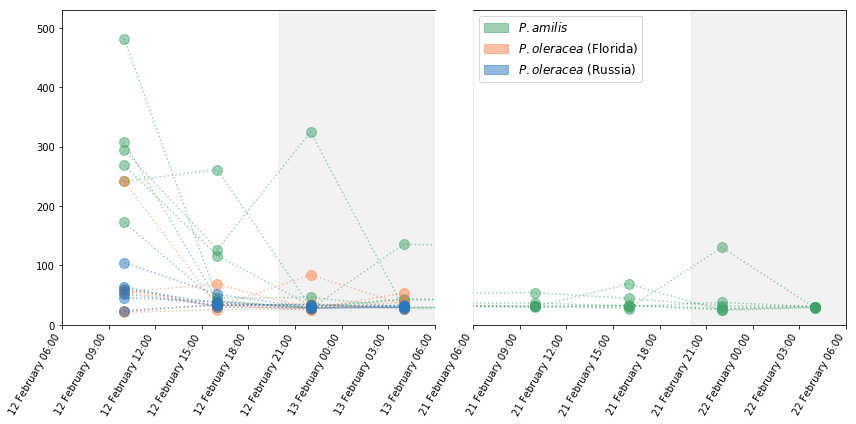

In [7]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (12,6), sharey=True)

for ax in [ax0, ax1]:
    for i in range(11, 23, 1):
        rect = mpatches.Rectangle((datetime(2019, 2, i, 20), 0), timedelta(hours = 10), 
                                  1000, color='grey', alpha=0.10)
        ax.add_patch(rect) 
    for sample in sorted(porometer["Acc_No"].unique()):
        if sample.startswith("AM"):
            ax.plot_date(x = porometer.loc[porometer["Acc_No"]==sample]["datetime"], 
                   y = porometer.loc[porometer["Acc_No"]==sample][["Leaf 1", "Leaf 2", "Leaf 3"]].mean(axis=1), 
                   color = "xkcd:greenish", marker = "o", alpha = 0.5, markersize=10, linestyle=":")
        if sample.startswith("OF"):
            ax.plot_date(x = porometer.loc[porometer["Acc_No"]==sample]["datetime"], 
                   y = porometer.loc[porometer["Acc_No"]==sample][["Leaf 1", "Leaf 2", "Leaf 3"]].mean(axis=1),
                   color = "xkcd:orangish", marker = "o", alpha = 0.5, markersize=10, linestyle=":")
        if sample.startswith("OR"):
            ax.plot_date(x = porometer.loc[porometer["Acc_No"]==sample]["datetime"], 
                   y = porometer.loc[porometer["Acc_No"]==sample][["Leaf 1", "Leaf 2", "Leaf 3"]].mean(axis=1), 
                   color = "xkcd:bluish", marker = "o", alpha = 0.5, markersize=10, linestyle=":")
            
green_patch = mpatches.Patch(color='xkcd:greenish', alpha=0.5, label='$P. amilis$')
orange_patch = mpatches.Patch(color='xkcd:orangish', alpha=0.5, label='$P. oleracea$ (Florida)')
blue_patch = mpatches.Patch(color='xkcd:bluish', alpha=0.5, label='$P. oleracea$ (Russia)')
ax1.legend(handles=[green_patch, orange_patch, blue_patch], fontsize=12, frameon=True)

ax0.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.yaxis.set_ticks_position('none') 

ax0.set_xlim([datetime(2019, 2, 12, 6), datetime(2019, 2, 13, 6)])
ax0.set_ylim([0, get_plot_height(ax=ax0, expansion=1.1)])
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%d %B %H:%M'))

ax1.set_xlim([datetime(2019, 2, 21, 6), datetime(2019, 2, 22, 6)])
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %B %H:%M'))
# ax.set_ylabel("$\mu eq$ H$^{+}\circ g^{-1}$")
fig.autofmt_xdate(rotation=60)
plt.tight_layout(w_pad=-2)
# plt.savefig("../Figures/porometer_data.pdf", dpi = 100, transparent=True)

# Experimental titrations

In [8]:
titrations = pd.read_csv("../Data/Titration_measurements.csv")
titrations["datetime"] = [datetime.strptime(dt, "%d %B %Y %H:%M") for dt in titrations["Collection time"]]
titrations["Genotype"] = [acc[:2] for acc in titrations["Acc_No"]]
titrations.head()

,Index,Collection time,Acc_No,Mass_g,pHi,uL_NaOH,pHf,ueq_H,Notes,datetime,Genotype
0,T_001,12 February 2019 16:00,AM02,0.44058,5.39,1975.0,7.03,8.965,NaN,2019-02-12 16:00:00,AM
1,T_002,12 February 2019 16:00,AM01,0.39618,5.78,1565.0,7.01,7.900,NaN,2019-02-12 16:00:00,AM
2,T_003,12 February 2019 16:00,OR01,0.20850,5.70,1478.0,7.05,14.177,NaN,2019-02-12 16:00:00,OR
3,T_004,12 February 2019 16:00,OR03,0.17567,5.43,1336.0,7.03,15.210,NaN,2019-02-12 16:00:00,OR
4,T_005,12 February 2019 16:00,AM03,0.28373,5.52,1024.0,7.02,7.218,NaN,2019-02-12 16:00:00,AM


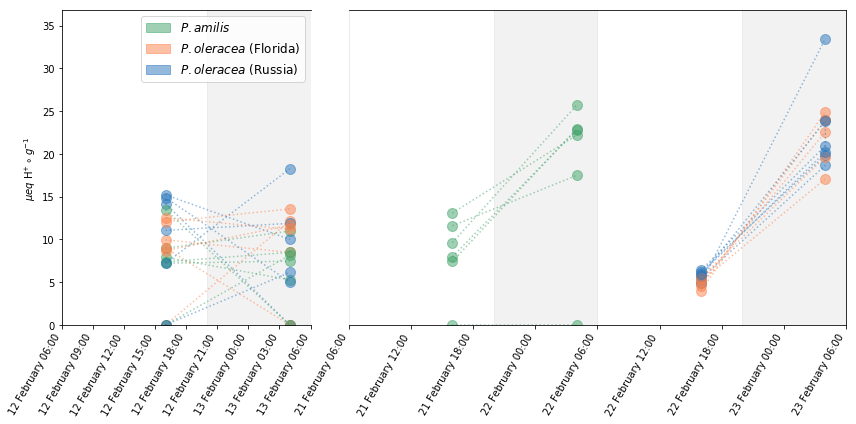

In [9]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (12,6), sharey=True, gridspec_kw = {'width_ratios':[1, 2]})

for ax in [ax0, ax1]:
    for i in range(11, 24, 1):
        rect = mpatches.Rectangle((datetime(2019, 2, i, 20), 0), timedelta(hours = 10), 
                                  1000, color='grey', alpha=0.10)
        ax.add_patch(rect) 
    
for acc in titrations["Acc_No"].unique():
    if acc.startswith("AM"):
        color = "xkcd:greenish"
        label = "$P. amilis$"
    if acc.startswith("OF"):
        color = "xkcd:orangish"
        label = "$P. oleraceae$ Florida"
    if acc.startswith("OR"):
        color = "xkcd:bluish"
        label = "$P. oleraceae$ Russia"

    ax0.plot_date(
        x = titrations.loc[(titrations["Acc_No"]==acc) & (titrations["datetime"]<datetime(2019,2,16))]["datetime"], 
        y = titrations.loc[(titrations["Acc_No"]==acc) & (titrations["datetime"]<datetime(2019,2,16))]["ueq_H"], 
        color = color, linestyle= ":", marker = "o", label = label, alpha = 0.5, markersize=10)
    ax1.plot_date(
        x = titrations.loc[(titrations["Acc_No"]==acc) & (titrations["datetime"]>datetime(2019,2,16))]["datetime"], 
        y = titrations.loc[(titrations["Acc_No"]==acc) & (titrations["datetime"]>datetime(2019,2,16))]["ueq_H"], 
        color = color, linestyle= ":", marker = "o", label = label, alpha = 0.5, markersize=10)

# Legend
green_patch = mpatches.Patch(color='xkcd:greenish', alpha=0.5, label='$P. amilis$')
orange_patch = mpatches.Patch(color='xkcd:orangish', alpha=0.5, label='$P. oleracea$ (Florida)')
blue_patch = mpatches.Patch(color='xkcd:bluish', alpha=0.5, label='$P. oleracea$ (Russia)')
ax0.legend(handles=[green_patch, orange_patch, blue_patch], fontsize=12, frameon=True)
# Partially remove frame
ax0.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.yaxis.set_ticks_position('none')
# Set plot limits
ax0.set_xlim([datetime(2019, 2, 12, 6), datetime(2019, 2, 13, 6)])
ax0.set_ylim([0, get_plot_height(ax=ax0, expansion=1.1)])
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%d %B %H:%M'))
ax1.set_xlim([datetime(2019, 2, 21, 6), datetime(2019, 2, 23, 6)])
ax1.set_ylim([0, titrations["ueq_H"].max()*1.1])
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %B %H:%M'))
# Format axes labels and adjust plot gaps
ax0.set_ylabel("$\mu eq$ H$^{+}\circ g^{-1}$")
fig.autofmt_xdate(rotation=60)
plt.tight_layout(w_pad=-2)
# plt.savefig("../Figures/titration_scatter.pdf", dpi = 100, transparent=True)

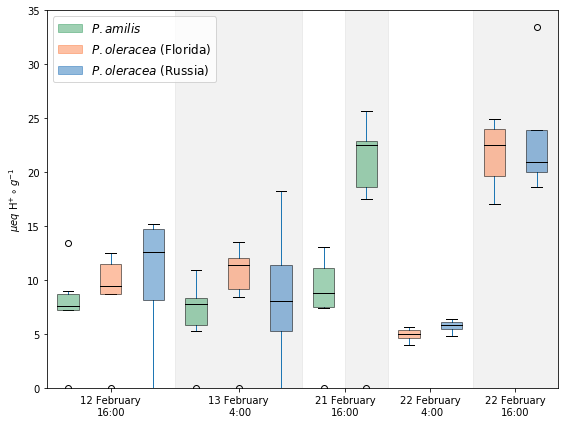

In [10]:
fig, ax = plt.subplots(figsize = (8,6))

nights = [[3.5, 6.5], [7.5, 8.5], [10.5, 12.5]]
for night in nights:
    rect = mpatches.Rectangle(xy=[night[0],0], width = night[1]-night[0], height= 40, color='grey', alpha=0.10)
    ax.add_patch(rect) 

boxplot_dict = titrations.boxplot(column=["ueq_H"], by=['datetime', 'Genotype'], ax=ax, 
                                  grid=False, return_type='both', patch_artist = True)

colors = ["xkcd:greenish", "xkcd:orangish", "xkcd:bluish",
          "xkcd:greenish", "xkcd:orangish", "xkcd:bluish",
          "xkcd:greenish", "xkcd:greenish", 
          "xkcd:orangish", "xkcd:bluish",
          "xkcd:orangish", "xkcd:bluish",]

for row_key, (ax,row) in boxplot_dict.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i])
        box.set_edgecolor("black")
        box.set_alpha(0.5)
    for i,median in enumerate(row['medians']):
        median.set_color("black")

green_patch = mpatches.Patch(color='xkcd:greenish', alpha=0.5, label='$P. amilis$')
orange_patch = mpatches.Patch(color='xkcd:orangish', alpha=0.5, label='$P. oleracea$ (Florida)')
blue_patch = mpatches.Patch(color='xkcd:bluish', alpha=0.5, label='$P. oleracea$ (Russia)')
ax.legend(handles=[green_patch, orange_patch, blue_patch], fontsize=12, frameon=True)

ax.set_xlim(0.5,12.5)
ax.set_ylim([0, 35])

ax.set_ylabel("$\mu eq$ H$^{+}\circ g^{-1}$")
ax.set_xlabel("")
ax.set_title("")
ax.set_xticks([2, 5, 7.5, 9.5, 11.5])
ax.set_xticklabels(["12 February\n16:00", "13 February\n 4:00", 
                    "21 February\n16:00", "22 February\n 4:00", 
                    "22 February\n16:00", "23 February\n 4:00",])
plt.suptitle("")
plt.tight_layout()
# plt.savefig("../Figures/titration_box.pdf", dpi = 100, transparent=True)

In [11]:
dH_dict = Vividict()
for acc, group in titrations.groupby("Acc_No"):
    try:
        dH_dict[acc]["Genotype"] = acc[:2]
        dH_dict[acc]["water"] = group.iloc[1]["ueq_H"]-group.iloc[0]["ueq_H"]
        dH_dict[acc]["drought"] = group.iloc[3]["ueq_H"]-group.iloc[2]["ueq_H"]
    except IndexError:
        next
        
dH = pd.DataFrame(dH_dict).T.reset_index()
dH.columns = ["Acc_No", "Genotype", "drought", "water"]
dH.head()

,Acc_No,Genotype,drought,water
0,AM01,AM,15.509,-2.631
1,AM02,AM,5.888,2.013
2,AM03,AM,0,0.232
3,AM04,AM,16.083,1.113
4,AM05,AM,9.097,8.139


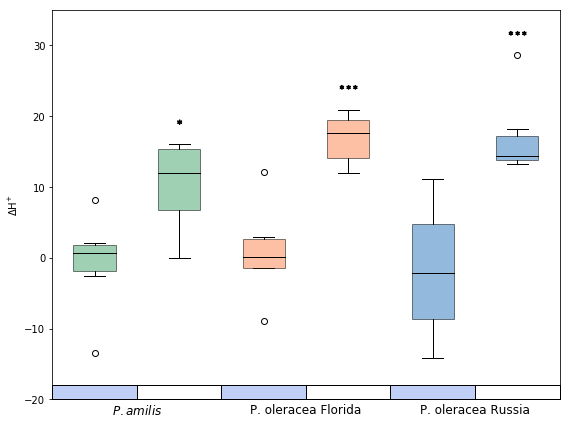

In [12]:
fig, ax = plt.subplots(figsize = (8,6))

for i in [0.5, 2.5, 4.5]:
    ax.add_patch(plt.Rectangle(xy = (i,-20), width = 1 , height = 2,
                               facecolor='xkcd:blue', alpha=0.25, clip_on=False, linewidth = 1))
    ax.add_patch(plt.Rectangle(xy = (i,-20), width = 1 , height = 2, 
                               facecolor="none", clip_on=False, edgecolor ="black", linewidth = 1))
ax.add_patch(plt.Rectangle(xy = (0.5,-20), width = 6 , height = 2, 
                           facecolor="none", clip_on=False, edgecolor ="black", linewidth = 1))

AM_w = dH.loc[dH["Genotype"]=="AM"]["water"]
AM_d = dH.loc[dH["Genotype"]=="AM"]["drought"]
OF_w = dH.loc[dH["Genotype"]=="OF"]["water"]
OF_d = dH.loc[dH["Genotype"]=="OF"]["drought"].dropna()
OR_w = dH.loc[dH["Genotype"]=="OR"]["water"]
OR_d = dH.loc[dH["Genotype"]=="OR"]["drought"]

boxplot = ax.boxplot(patch_artist=True, x = [AM_w, AM_d, OF_w, OF_d, OR_w, OR_d])

for i, dist in enumerate([AM_w, AM_d, OF_w, OF_d, OR_w, OR_d]):
    result = stats.ttest_1samp(a=dist, popmean=0)
    if result.pvalue < 0.001: 
        marker = "$*$ $*$ $*$"
        size = 300
    elif result.pvalue < 0.01: 
        marker = "$*$ $*$"
        size = 300
    elif result.pvalue < 0.05: 
        marker = "$*$"
        size = 50
    else: 
        marker = ""
        size = 50
    ax.scatter(x = i+1, y = max(dist)+3, marker=marker, c="black", s=size)

colors = ["xkcd:greenish", "xkcd:greenish", "xkcd:orangish", "xkcd:orangish", "xkcd:bluish", "xkcd:bluish"]
for color, box in zip(colors, boxplot["boxes"]):
    box.set_color(color)
    box.set_alpha(0.5)
    box.set_edgecolor("black")
for median in boxplot['medians']:
    median.set_color("black")   
    
ax.set_ylim([-20, 35])
ax.set_xticks([1.5, 3.5, 5.5])
ax.set_xticklabels(["$P. amilis$", "P. oleracea Florida", "P. oleracea Russia"], size=12)
ax.tick_params(axis='x', size=0)
ax.set_ylabel("$\Delta$H$^{+}$")
plt.tight_layout()
# plt.savefig("../Figures/deltaH_box.pdf", dpi = 100, transparent=True)